# Hospital Discharge

In this code, we will be exploring a dataset of patient hospital discharge outcomes as a function of the treatment they receive. We will explore how to work with very wide datasets using dimensionality reduction techniques.

## Import packages

First, we will import our normal selection of packages. However, this time, we will be importing the classification version of the models we've been using. These will have different names, but generally, the parameters will be identical or nearly so.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import dill

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, f1_score, confusion_matrix, plot_roc_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

from patsy import dmatrices, dmatrix, build_design_matrices, demo_data

# Set number of CPU cores for parallel algorithms
import os
if "CPU_LIMIT" in os.environ:
    # If you are on JupyterHub, this gives you the right number of CPUs for your virtual machine
    num_cpus = int(os.getenv("CPU_LIMIT").split('.')[0])
else:
    # If you are not on JupyterHub, this gives you the right number for your computer.
    num_cpus = os.cpu_count()

In [2]:
# This sets some nicer defaults for plotting.
# This must be run in a separate cell from importing matplotlib due to a bug.
params = {'legend.fontsize': 'large',
          'figure.figsize': (11.0, 11.0),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
mpl.rcParams.update(params)

# This makes it so that the pandas dataframes don't get truncated horizontally.
pd.options.display.max_columns = 200

## Load the Data

This data set is quite wide.

In [3]:
df_train = pd.read_csv("DischargeTrain.csv")
df_test = pd.read_csv("DischargeTest.csv")

In [5]:
df_train.shape

(17435, 833)

In [6]:
df_test

Unique_Patient_Encounter_ID                  Discharge_Type  \
0                        37607139  Skilled Nursing Facility (SNF)   
1                        34657024  Skilled Nursing Facility (SNF)   
2                        30057022              Home Health Agency   
3                        31740931                            HOME   
4                        32525312              Home Health Agency   
...                           ...                             ...   
5807                     35102500              Home Health Agency   
5808                     36450000              Home Health Agency   
5809                     30322787                            HOME   
5810                     26366698  Long Term Care Hospital (LTCH)   
5811                     28609616                            HOME   

      Unique_Patient_ID     Sex Marital_Status          Payment_Class  \
0                227723  Female       Divorced               Medicare   
1                188569  Female        Widowed               Medicare   
2                963231  Female        Married               Medicare   
3               2348674  Female        Married   Medicare Replacement   
4                 98379    Male       Divorced               Medicare   
...                 ...     ...            ...                    ...   
5807             398284    Male        Married               Medicare   
5808             808171    Male        Married  Medicare Managed Care   
5809             408660    Male        Married            Blue Shield   
5810             276046  Female         Single               Medicaid   
5811             971171    Male         Single               Self-pay   

     Previous_Discharge_Type  Age  ReadmissionCount  \
0                        NaN   89                 0   
1                        NaN   80                 0   
2                       HOME   68                 1   
3                        NaN   40                 0   
4                        NaN   68                 0   
...                      ...  ...               ...   
5807                     NaN   73                 1   
5808                     NaN   75                 2   
5809                     NaN   62                 0   
5810                     NaN   41                 1   
5811                     NaN   61                 0   

      Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx)  \
0                                                    10                              
1                                                     0                              
2                                                     0                              
3                                                     1                              
4                                                     0                              
...                                                 ...                              
5807                                                  0                              
5808                                                  0                              
5809                                                  0                              
5810                                                  0                              
5811                                                  0                              

      Diseases of the circulatory system-Diseases of arteries; arterioles; and capillaries+Count*(sk_dim_dx)  \
0                                                     1                                                        
1                                                     0                                                        
2                                                     0                                                        
3                                                     0                                                        
4                                             

Let's take a look at the shape of these dataframes.

In [7]:
df_train.shape

(17435, 833)

In [8]:
df_test.shape

(5812, 833)

We have a lot of columns.

## Summarize the data

Let's take a more holistic look at the data.

In [6]:
def summarize_dataframe(df):
    """Summarize a dataframe, and report missing values."""
    missing_values = pd.DataFrame({'Variable Name': df.columns,
                                   'Data Type': df.dtypes,
                                   'Missing Values': df.isnull().sum(),
                                   'Unique Values': [df[name].nunique() for name in df.columns]}
                                 ).set_index('Variable Name')
    with pd.option_context("display.max_rows", 1000):
        display(pd.concat([missing_values, df.describe(include='all').transpose()], axis=1).fillna(""))

In [7]:
summarize_dataframe(df_train)

Data Type  Missing Values  \
Unique_Patient_Encounter_ID                            int64               0   
Discharge_Type                                        object               0   
Unique_Patient_ID                                      int64               0   
Sex                                                   object               0   
Marital_Status                                        object               0   
Payment_Class                                         object               0   
Previous_Discharge_Type                               object           14578   
Age                                                    int64               0   
ReadmissionCount                                       int64               0   
Diseases of the circulatory system-Cerebrovascu...     int64               0   
Diseases of the circulatory system-Diseases of ...     int64               0   
Diseases of the musculoskeletal system and conn...     int64               0   
Diseases of the musculoskeletal system and conn...     int64               0   
Diseases of the musculoskeletal system and conn...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Endocrine; nutritional; and metabolic diseases ...     int64               0   
Injury and poisoning-Fractures+Count*(sk_dim_dx)       int64               0   
Residual codes; unclassified; all E codes [259....     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Infectious and parasitic diseases-Immunizations...     int64               0   
Symptoms; signs; and ill-defined conditions and...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Symptoms; signs; and ill-defined conditions and...     int64               0   
Diseases of the digestive system-Upper gastroin...     int64               0   
Diseases of the genitourinary system-Diseases o...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Diseases of the genitourinary system-Diseases o...     int64               0   
Injury and poisoning-Poisoning+Count*(sk_dim_dx)       int64               0   
Mental Illness-Anxiety disorders [651]+Count*(s...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Mental Illness-Screening and history of mental ...     int64               0   
Diseases of the respiratory system-Other upper ...     int64               0   
Congenital anomalies-Other congenital anomalies...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Infectious and parasitic diseases-Bacterial inf...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Mental Illness-Miscellaneous mental disorders [...     int64               0   
Diseases of the blood and blood-forming organs-...     int64               0   
Diseases of the circulatory system-Diseases of ...     int64               0   
Diseases of the digestive system-Other gastroin...     int64               0   
Injury and poisoning-Intracranial injury [233.]...     int64               0   
Mental Illness-Mood disorders [657]+Count*(sk_d...     int64               0   
Mental Illness-Substance-related disorders [661...     int64               0   
Infectious and parasitic diseases-Viral infecti...     int64               0   
Injury and poisoning-Complications+Count*(sk_di... 

The above summary is much longer than what we are used to seeing becuase this dataset has significantly more columns. Moreover, most of the columns are difficult, if not impossible, to interpret without a medical degree. Let's look at the columns we can interpret.

NOTE: I made the output scroll by right clicking on the blue bar at the side of the cell (when the cell is selected) and selecting "Enable Scrolling for Outputs". That makes the notebook much more readable.

In [8]:
df_train.columns[:9]

Index(['Unique_Patient_Encounter_ID', 'Discharge_Type', 'Unique_Patient_ID',
       'Sex', 'Marital_Status', 'Payment_Class', 'Previous_Discharge_Type',
       'Age', 'ReadmissionCount'],
      dtype='object')

The first nine columns are all likely to be useful features (or the dependent variable). However, the remaining columns are all effectively inscrutable and quite sparse. To check the sparsity, we can check the number of distinct values for a column as follows.

In [12]:
df_train['Diseases of the musculoskeletal system and connective tissue-Acquired deformities+Count*(sk_dim_dx)'].value_counts()

0     15942
1       656
2       292
3       171
4       111
5        76
7        53
6        47
8        30
9        19
10       12
11        8
12        5
13        3
14        2
19        1
22        1
27        1
29        1
23        1
16        1
18        1
15        1
Name: Diseases of the musculoskeletal system and connective tissue-Acquired deformities+Count*(sk_dim_dx), dtype: int64

As we can see, the vast majority of values for `Diseases of the musculoskeletal system and connective tissue-Acquired deformities+Count*(sk_dim_dx)` are 0. This is generally true for most of the columns since they report particular medical conditions (and number of them) or particular medications.

Additionally, we need to determine what a good target variable would be. We can see the possible discharge types as below:

In [9]:
df_train['Discharge_Type'].value_counts()

Home Health Agency                                        5696
HOME                                                      4790
Skilled Nursing Facility (SNF)                            3025
Acute Rehabilitation Facility (hospital or unit) (IRF)    1150
EXPIRED                                                    972
Infusion / Home                                            712
Long Term Care Hospital (LTCH)                             395
Hospice / Home                                             367
DIS TO LAW ENFORCE                                         166
AGAINST MED ADVICE                                         162
Name: Discharge_Type, dtype: int64

The types of discharge that require additional paperwork are `Skilled Nursing Facility (SNF)`, `Acute Rehabilitation Facility (hospital or unit) (IRF)`, and `Long Term Care Hospital (LTCH)`, so we will create a new variable which is `1` if any of those three are the discharge type or `0` if not.

In [10]:
df_train["Requires_Paperwork"] = df_train["Discharge_Type"].isin(['Skilled Nursing Facility (SNF)', 'Acute Rehabilitation Facility (hospital or unit) (IRF)', 'Long Term Care Hospital (LTCH)']).astype(int)

In [11]:
df_train[['Discharge_Type', 'Requires_Paperwork']].head(30)

Discharge_Type  Requires_Paperwork
0                                  Home Health Agency                   0
1                                     Infusion / Home                   0
2                      Skilled Nursing Facility (SNF)                   1
3                                  Home Health Agency                   0
4                      Skilled Nursing Facility (SNF)                   1
5   Acute Rehabilitation Facility (hospital or uni...                   1
6                                             EXPIRED                   0
7                                  Home Health Agency                   0
8                                  Home Health Agency                   0
9                                  Home Health Agency                   0
10                                 Home Health Agency                   0
11                     Skilled Nursing Facility (SNF)                   1
12                                 Home Health Agency                   0
13                                               HOME                   0
14                                               HOME                   0
15                                 Home Health Agency                   0
16                                            EXPIRED                   0
17                                 Home Health Agency                   0
18                                 Home Health Agency                   0
19                                 Home Health Agency                   0
20                                 AGAINST MED ADVICE                   0
21                                               HOME                   0
22                     Skilled Nursing Facility (SNF)                   1
23                                 Home Health Agency                   0
24                     Skilled Nursing Facility (SNF)                   1
25  Acute Rehabilitation Facility (hospital or uni...                   1
26                                 Home Health Agency                   0
27                     Skilled Nursing Facility (SNF)                   1
28                                 Home Health Agency                   0
29                                 Home Health Agency                   0

We now have a column that is `True` if the dischage requires paperwork and `False` otherwise. However, it's at the end of our dataset, and it will be more convenient if it was at the beginning. We can shuffle the columns using the below:

In [12]:
df_train = df_train[['Requires_Paperwork'] + df_train.columns[:-1].to_list()]

In [13]:
df_train

Requires_Paperwork  Unique_Patient_Encounter_ID  \
0                       0                     33434057   
1                       0                     38150727   
2                       1                     38277211   
3                       0                     25738323   
4                       1                     39051989   
...                   ...                          ...   
17430                   1                     26337341   
17431                   0                     36451219   
17432                   0                     28890690   
17433                   0                     26382774   
17434                   0                     32259454   

                       Discharge_Type  Unique_Patient_ID     Sex  \
0                  Home Health Agency             298873  Female   
1                     Infusion / Home             165661    Male   
2      Skilled Nursing Facility (SNF)             152726    Male   
3                  Home Health Agency             248404  Female   
4      Skilled Nursing Facility (SNF)             903860  Female   
...                               ...                ...     ...   
17430  Skilled Nursing Facility (SNF)             575386    Male   
17431                         EXPIRED            2398488  Female   
17432                  Hospice / Home             196280  Female   
17433              Home Health Agency             195700  Female   
17434                            HOME            1939659    Male   

      Marital_Status          Payment_Class         Previous_Discharge_Type  \
0             Single   Medicare Replacement                             NaN   
1           Divorced             Do not use                             NaN   
2            Married  Medicare Managed Care                             NaN   
3            Married   Medicare Replacement                             NaN   
4            Married               Medicare  Skilled Nursing Facility (SNF)   
...              ...                    ...                             ...   
17430        Married                  Grant                             NaN   
17431        Widowed               Medicare                             NaN   
17432        Married               Medicare                             NaN   
17433        Married            Blue Shield                             NaN   
17434         Single               Agencies                             NaN   

       Age  ReadmissionCount  \
0       54                 1   
1       58                 1   
2       73                 0   
3       61                 0   
4       72                 0   
...    ...               ...   
17430   84                 0   
17431   87                 0   
17432   80                 0   
17433   62                 0   
17434   62                 0   

       Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx)  \
0                                                      0                              
1                                                      0                              
2                                                      0                              
3                                                      0                              
4                                                     13                              
...                                                  ...                              
17430                                                  0                              
17431                                                  0                              
17432                                                  8                              
17433                                                  0                              
17434                                                  0                              

       Diseases of the circulatory system-Diseases of arteries; arterioles; and capillaries+Count*(sk_dim_dx)  \
0

We can see that worked. Now lets drop `Discharge_Type` to avoid accidentally using it in our model.

In [14]:
df_train.drop(columns=['Discharge_Type'], inplace=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Now we need to do the same thing with the test data set.

In [15]:
df_test["Requires_Paperwork"] = df_test["Discharge_Type"].isin(['Skilled Nursing Facility (SNF)', 'Acute Rehabilitation Facility (hospital or unit) (IRF)', 'Long Term Care Hospital (LTCH)']).astype(int)
df_test = df_test[['Requires_Paperwork'] + df_test.columns[:-1].to_list()]
df_test.drop(columns=['Discharge_Type'], inplace=True)

In [16]:
df_test

Requires_Paperwork  Unique_Patient_Encounter_ID  Unique_Patient_ID  \
0                      1                     37607139             227723   
1                      1                     34657024             188569   
2                      0                     30057022             963231   
3                      0                     31740931            2348674   
4                      0                     32525312              98379   
...                  ...                          ...                ...   
5807                   0                     35102500             398284   
5808                   0                     36450000             808171   
5809                   0                     30322787             408660   
5810                   1                     26366698             276046   
5811                   0                     28609616             971171   

         Sex Marital_Status          Payment_Class Previous_Discharge_Type  \
0     Female       Divorced               Medicare                     NaN   
1     Female        Widowed               Medicare                     NaN   
2     Female        Married               Medicare                    HOME   
3     Female        Married   Medicare Replacement                     NaN   
4       Male       Divorced               Medicare                     NaN   
...      ...            ...                    ...                     ...   
5807    Male        Married               Medicare                     NaN   
5808    Male        Married  Medicare Managed Care                     NaN   
5809    Male        Married            Blue Shield                     NaN   
5810  Female         Single               Medicaid                     NaN   
5811    Male         Single               Self-pay                     NaN   

      Age  ReadmissionCount  \
0      89                 0   
1      80                 0   
2      68                 1   
3      40                 0   
4      68                 0   
...   ...               ...   
5807   73                 1   
5808   75                 2   
5809   62                 0   
5810   41                 1   
5811   61                 0   

      Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx)  \
0                                                    10                              
1                                                     0                              
2                                                     0                              
3                                                     1                              
4                                                     0                              
...                                                 ...                              
5807                                                  0                              
5808                                                  0                              
5809                                                  0                              
5810                                                  0                              
5811                                                  0                              

      Diseases of the circulatory system-Diseases of arteries; arterioles; and capillaries+Count*(sk_dim_dx)  \
0                                                     1                                                        
1                                                     0                                                        
2                                                     0                                                        
3                                                     0                                                        
4                                                     0                                                        
...                                                 ...                       

We also can drop the `Unique_Patient_Encounter_ID`. This effectively serves as an index.

In [17]:
df_train.drop(columns=['Unique_Patient_Encounter_ID'], inplace=True)
df_test.drop(columns=['Unique_Patient_Encounter_ID'], inplace=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Let's check out the dataframe one more time to make sure everything is as we want it.

In [18]:
summarize_dataframe(df_train)

Data Type  Missing Values  \
Requires_Paperwork                                     int64               0   
Unique_Patient_ID                                      int64               0   
Sex                                                   object               0   
Marital_Status                                        object               0   
Payment_Class                                         object               0   
Previous_Discharge_Type                               object           14578   
Age                                                    int64               0   
ReadmissionCount                                       int64               0   
Diseases of the circulatory system-Cerebrovascu...     int64               0   
Diseases of the circulatory system-Diseases of ...     int64               0   
Diseases of the musculoskeletal system and conn...     int64               0   
Diseases of the musculoskeletal system and conn...     int64               0   
Diseases of the musculoskeletal system and conn...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Endocrine; nutritional; and metabolic diseases ...     int64               0   
Injury and poisoning-Fractures+Count*(sk_dim_dx)       int64               0   
Residual codes; unclassified; all E codes [259....     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Infectious and parasitic diseases-Immunizations...     int64               0   
Symptoms; signs; and ill-defined conditions and...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Symptoms; signs; and ill-defined conditions and...     int64               0   
Diseases of the digestive system-Upper gastroin...     int64               0   
Diseases of the genitourinary system-Diseases o...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Diseases of the genitourinary system-Diseases o...     int64               0   
Injury and poisoning-Poisoning+Count*(sk_dim_dx)       int64               0   
Mental Illness-Anxiety disorders [651]+Count*(s...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Mental Illness-Screening and history of mental ...     int64               0   
Diseases of the respiratory system-Other upper ...     int64               0   
Congenital anomalies-Other congenital anomalies...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Infectious and parasitic diseases-Bacterial inf...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Mental Illness-Miscellaneous mental disorders [...     int64               0   
Diseases of the blood and blood-forming organs-...     int64               0   
Diseases of the circulatory system-Diseases of ...     int64               0   
Diseases of the digestive system-Other gastroin...     int64               0   
Injury and poisoning-Intracranial injury [233.]...     int64               0   
Mental Illness-Mood disorders [657]+Count*(sk_d...     int64               0   
Mental Illness-Substance-related disorders [661...     int64               0   
Infectious and parasitic diseases-Viral infecti...     int64               0   
Injury and poisoning-Complications+Count*(sk_di...     int64               0   
Diseases of the respiratory system-Asthma [128.... 

Now we are ready to start working with the data.

## Engineer features

As long as we don't need to use any information other than what we have, we can go ahead and engineer new features on the full training set. By default we will not do any feature engineering by row, but you may choose to do so.

Note that any feature engineering that can't be done with only a single row of data (i.e. you need the mean of a whole column), should only be done after splitting.

## Split Into Training and Validation

Now we will split the train dataset into a smaller training and a validation set, as is best practice.

In [19]:
df_smaller_train, df_validation = train_test_split(df_train, test_size = 0.25, random_state = 201)

There is a bug that gives a warning later on in the code which you can fix by making copies of the above dataframe. This step is unnecessary, but it avoids showing a warning, so I'm going to include it.

In [20]:
df_smaller_train = df_smaller_train.copy()
df_validation = df_validation.copy()

## Imputing Missing Values

There aren't any missing values in this dataset, except for previous discharge type for which missing means there is no previous discharge, but it's good practice to train imputers anyway in case new data arrives that has missing values that needs to be impute upon.

It would be infeasible to go through all of the variables and figure out the right imputer, but luckily, there is a fairly obvious strategy for most of the variables (i.e. all of the ones at the end of the data set). Those variables all are counts of conditions or medications, so we can reasonably impute that if something is missing, it should be a `0`.

So, we will create a continuous imputer that imputes the mean for the `Age` variable. The `Readmission_Count` probably should be imputed as a `0`, and all of the other variables seem to be categorical and should be imputed with a categorical imputer. We will impute with the `"OTHER"` category since there isn't anything missing in the data. The exception to this will be the `Previous_Discharge_Type` which a missing value means none, so we will fill it in with `"NONE"`

In [21]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalImputer(BaseEstimator, TransformerMixin):
    """
    Custom defined imputer for categorical data. This allows you to specify an 
    other class where any category that doesn't meet the requirements necessary to
    be in 
    """
    
    def __init__(self, other_threshold=0, 
                 other_label="OTHER",
                 missing_first=True,
                 missing_values=np.nan, 
                 strategy='constant', 
                 fill_value="MISSING", 
                 verbose=0, 
                 copy=True, 
                 add_indicator=False):
        self.add_indicator = add_indicator
        self.copy=copy
        self.verbose=verbose
        self.fill_value=fill_value
        self.missing_first=missing_first
        self.missing_values=missing_values
        self.other_label=other_label
        self.other_threshold=other_threshold
        self.strategy=strategy
        if hasattr(missing_values, "__iter__"):
            self.missing_values = missing_values
        else:
            self.missing_values = [missing_values]
        self._imputer = SimpleImputer(missing_values=missing_values, strategy=strategy, fill_value=fill_value, verbose=verbose, copy=copy, add_indicator=False)
        self._column_categories = {}

        
    def fit(self, X, y=None):
        if type(self.other_threshold) == int or type(self.other_threshold) == float:
            other_threshold = [self.other_threshold]*len(X.columns)
        elif len(self.other_threshold) == len(X.columns):
            other_threshold = self.other_threshold
        else:
            raise TypeError("other_threshold must be either a single number or a list of numbers equal to the number of columns.")

        i = 0
        X = X.copy()
        X = X[:].astype(object)
        if self.missing_first:
            X = pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)
        column_categories = {}
        for column in X.columns:
            if other_threshold[i] < 1:
                other_threshold[i] = other_threshold[i]*X[column].shape[0]
            
            value_counts = X[column].value_counts()
            categories = [category for category in value_counts.index if value_counts.loc[category] >= other_threshold[i]]
            if value_counts.iloc[-1] >= other_threshold[i]:
                categories[-1] = self.other_label
            else:
                categories.append(self.other_label)
            
            self._column_categories[column] = categories
            i = i + 1
        
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        X = X[:].astype(object)
        if self.missing_first:
            X = pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)
        for column in X.columns:
            X.loc[~X[column].isin(self._column_categories[column]) & ~X[column].isin(self.missing_values), column] = self.other_label
        return pd.DataFrame(self._imputer.fit_transform(X), columns=X.columns, index=X.index)[:].astype(str)

In [22]:
continuous_imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
continuous_imputer_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
categorical_imputer_other = CategoricalImputer(other_threshold=0, fill_value="OTHER")
categorical_imputer_none = CategoricalImputer(other_threshold=0, fill_value="NONE")
# categorical_imputer_other = CategoricalImputer()
# categorical_imputer_none = CategoricalImputer()

Now we will create sets of variables that correspond to the imputers we will use. Let's look at the variables that we will customize to make sure we've got all of them.

In [23]:
df_train.columns[:8]

Index(['Requires_Paperwork', 'Unique_Patient_ID', 'Sex', 'Marital_Status',
       'Payment_Class', 'Previous_Discharge_Type', 'Age', 'ReadmissionCount'],
      dtype='object')

In [24]:
continuous_features_mean = ["Age"]
continuous_features_zero = ['ReadmissionCount'] + df_train.columns[8:].to_list()
categorical_features_other = ["Unique_Patient_ID", "Sex", "Marital_Status", "Payment_Class"]
categorical_features_none = ["Previous_Discharge_Type"]

It's good to ensure that we did indeed get all the variables, so let's add them up and make sure the count is right.

In [25]:
len(continuous_features_mean + continuous_features_zero + categorical_features_other + categorical_features_none)

831

We can compare that to our original column list.

In [26]:
df_train.shape

(17435, 832)

Our imputing variables is one less because we don't impute on `Requires_Paperwork` since that is the target variable.

Then we can impute the columns all in one fell swoop.

In [27]:
continuous_imputer_mean.fit(df_smaller_train[continuous_features_mean])
continuous_imputer_zero.fit(df_smaller_train[continuous_features_zero])
categorical_imputer_other.fit(df_smaller_train[categorical_features_other])
categorical_imputer_none.fit(df_smaller_train[categorical_features_none])

CategoricalImputer(fill_value='NONE', missing_values=[nan])

Now we can impute on the smaller train and validation sets.

In [28]:
df_smaller_train.loc[:, continuous_features_mean] = continuous_imputer_mean.transform(df_smaller_train[continuous_features_mean])
df_smaller_train.loc[:, continuous_features_zero] = continuous_imputer_zero.transform(df_smaller_train[continuous_features_zero])
df_smaller_train.loc[:, categorical_features_other] = categorical_imputer_other.transform(df_smaller_train[categorical_features_other])
df_smaller_train.loc[:, categorical_features_none] = categorical_imputer_none.transform(df_smaller_train[categorical_features_none])

df_validation.loc[:, continuous_features_mean] = continuous_imputer_mean.transform(df_validation[continuous_features_mean])
df_validation.loc[:, continuous_features_zero] = continuous_imputer_zero.transform(df_validation[continuous_features_zero])
df_validation.loc[:, categorical_features_other] = categorical_imputer_other.transform(df_validation[categorical_features_other])
df_validation.loc[:, categorical_features_none] = categorical_imputer_none.transform(df_validation[categorical_features_none])

We can check the dataframe one more time to make sure that things happened as expected.

In [29]:
summarize_dataframe(df_smaller_train)

Data Type  Missing Values  \
Requires_Paperwork                                     int64               0   
Unique_Patient_ID                                     object               0   
Sex                                                   object               0   
Marital_Status                                        object               0   
Payment_Class                                         object               0   
Previous_Discharge_Type                               object               0   
Age                                                  float64               0   
ReadmissionCount                                       int64               0   
Diseases of the circulatory system-Cerebrovascu...     int64               0   
Diseases of the circulatory system-Diseases of ...     int64               0   
Diseases of the musculoskeletal system and conn...     int64               0   
Diseases of the musculoskeletal system and conn...     int64               0   
Diseases of the musculoskeletal system and conn...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Endocrine; nutritional; and metabolic diseases ...     int64               0   
Injury and poisoning-Fractures+Count*(sk_dim_dx)       int64               0   
Residual codes; unclassified; all E codes [259....     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Infectious and parasitic diseases-Immunizations...     int64               0   
Symptoms; signs; and ill-defined conditions and...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Symptoms; signs; and ill-defined conditions and...     int64               0   
Diseases of the digestive system-Upper gastroin...     int64               0   
Diseases of the genitourinary system-Diseases o...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Diseases of the genitourinary system-Diseases o...     int64               0   
Injury and poisoning-Poisoning+Count*(sk_dim_dx)       int64               0   
Mental Illness-Anxiety disorders [651]+Count*(s...     int64               0   
Complications of pregnancy; childbirth; and the...     int64               0   
Mental Illness-Screening and history of mental ...     int64               0   
Diseases of the respiratory system-Other upper ...     int64               0   
Congenital anomalies-Other congenital anomalies...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Infectious and parasitic diseases-Bacterial inf...     int64               0   
Diseases of the nervous system and sense organs...     int64               0   
Mental Illness-Miscellaneous mental disorders [...     int64               0   
Diseases of the blood and blood-forming organs-...     int64               0   
Diseases of the circulatory system-Diseases of ...     int64               0   
Diseases of the digestive system-Other gastroin...     int64               0   
Injury and poisoning-Intracranial injury [233.]...     int64               0   
Mental Illness-Mood disorders [657]+Count*(sk_d...     int64               0   
Mental Illness-Substance-related disorders [661...     int64               0   
Infectious and parasitic diseases-Viral infecti...     int64               0   
Injury and poisoning-Complications+Count*(sk_di...     int64               0   
Diseases of the respiratory system-Asthma [128.... 

## Scale Continuous Variables

As we have done before, particularly when using linear models, we will scale the continuous variables so that all mean are mean `0` and standard deviation `1`. However, this time we will go ahead and scale all the variables ahead of time using the `StandardScaler` provided by `sklearn`.

In [30]:
scaler = StandardScaler()
scaler.fit(df_smaller_train[continuous_features_mean + continuous_features_zero])

StandardScaler()

Now we can scale the variables.

In [31]:
df_smaller_train[continuous_features_mean + continuous_features_zero] = scaler.transform(df_smaller_train[continuous_features_mean + continuous_features_zero])

In [32]:
df_validation[continuous_features_mean + continuous_features_zero] = scaler.transform(df_validation[continuous_features_mean + continuous_features_zero])

## Set Up the Scoring Rules

We will use the AUC for our score.

Let's check what AUC score if we just predict that everyone has the probability of needing the paperwork done equal to the average number in the training set, just to get a baseline.

In [33]:
naive = np.repeat(np.mean(df_smaller_train['Requires_Paperwork']), len(df_smaller_train['Requires_Paperwork']))
roc_auc_score(df_smaller_train['Requires_Paperwork'], naive)

0.5

Not good at all, which shouldn't be a surprise. We are predicting the same thing for everyone.

## Random Forest

Let's first try to build a random forest. Since we don't really know what variables will matter, let's just use them all.

First, we will set up our `X` and `y` matrices for the Random Forest Classifier. Note we don't include unique patient ID because that is a lot of possible values, and unlikely to be too useful.

In [38]:
X_train_tree = df_smaller_train[df_smaller_train.columns[2:]].copy()
y_train_tree = df_smaller_train['Requires_Paperwork'].copy()

Then we will encode the categorical variables with an ordinal encoder.

In [39]:
categorical_variables = ["Sex", "Marital_Status", "Payment_Class", "Previous_Discharge_Type"]
ordinal_encoder = OrdinalEncoder()

Note that we only want to use the categorical variables, so this is where it is handy that we went ahead and figured out which of our selected variables were categorical above.

In [40]:
ordinal_encoder.fit(X_train_tree[categorical_variables])
X_train_tree[categorical_variables] = ordinal_encoder.transform(X_train_tree[categorical_variables])

We can see that all of the values are now numeric, which means we can use them to build our decision tree.

In [41]:
X_train_tree

Sex  Marital_Status  Payment_Class  Previous_Discharge_Type       Age  \
11572  1.0             2.0            6.0                      7.0  1.292643   
5257   0.0             2.0            6.0                      7.0  1.230061   
6798   1.0             2.0            1.0                      7.0 -0.084142   
16229  1.0             5.0            6.0                      7.0  1.730710   
10385  1.0             2.0            6.0                      7.0  1.042318   
...    ...             ...            ...                      ...       ...   
10428  0.0             5.0            6.0                      7.0  1.417805   
9082   1.0             4.0            1.0                      7.0 -1.711251   
1891   0.0             2.0           10.0                      7.0 -0.209304   
501    1.0             4.0            6.0                      7.0 -1.711251   
7680   0.0             4.0            1.0                      7.0  0.166183   

       ReadmissionCount  \
11572          0.474325   
5257          -0.436970   
6798          -0.436970   
16229          0.474325   
10385         -0.436970   
...                 ...   
10428          0.474325   
9082          -0.436970   
1891          -0.436970   
501           -0.436970   
7680          -0.436970   

       Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx)  \
11572                                          -0.212584                              
5257                                           -0.212584                              
6798                                           -0.212584                              
16229                                          -0.212584                              
10385                                          -0.212584                              
...                                                  ...                              
10428                                          -0.212584                              
9082                                           -0.212584                              
1891                                           -0.212584                              
501                                            -0.212584                              
7680                                           -0.212584                              

       Diseases of the circulatory system-Diseases of arteries; arterioles; and capillaries+Count*(sk_dim_dx)  \
11572                                          -0.285347                                                        
5257                                           -0.285347                                                        
6798                                            0.069498                                                        
16229                                          -0.285347                                                        
10385                                          -0.285347                                                        
...                                                  ...                                                        
10428                                          -0.285347                                                        
9082                                           -0.285347                                                        
1891                                           -0.285347                                                        
501                                            -0.285347                                                        
7680                                           -0.285347                                                        

       Diseases of the musculoskeletal system and connective tissue-Acquired deformities+Count*(sk_dim_dx)  \
11572                                          -0.213949                                                     
5257                                           -0.213949                                           

Let's build our random frest. Note that the only difference between this and the decision tree regression we've used before is the function is called `RandomForestClassifier` instead of `RandomForestRegressor`.

In [42]:
rf_model = RandomForestClassifier(n_estimators=500, max_features=4, min_samples_leaf=5, random_state=201, n_jobs=num_cpus)

In [43]:
rf_model.fit(X_train_tree, y_train_tree)

RandomForestClassifier(max_features=4, min_samples_leaf=5, n_estimators=500,
                       n_jobs=2, random_state=201)

We can also look at the feature importance.

In [44]:
pd.DataFrame({'Importance': rf_model.feature_importances_}, index=X_train_tree.columns).sort_values(['Importance'], ascending=False)

Importance
Subacute rehab/SNF+First*(PTValue)                    0.058800
Acute Rehabilitation+First*(OTValue)                  0.051954
Sub-Acute Rehab/SNF+First*(OTValue)                   0.047783
Acute rehab+First*(PTValue)                           0.038765
Medicine Services and Procedures-Physical Medic...    0.020799
...                                                        ...
Respiratory Agents-Antiasthmatic-Antiasthmatic ...    0.000000
Antineoplastic Agents-Antineoplastics-Antineopl...    0.000000
Endocrine & Metabolic Drugs-Oxytocics-Oxytocics...    0.000000
Endocrine & Metabolic Drugs-Oxytocics-Abortifac...    0.000000
AMPAC_Scaled_Score                                    0.000000

[830 rows x 1 columns]

Now, let's prepare our validation data to test on.

In [45]:
X_validation_tree = df_validation[df_smaller_train.columns[2:]].copy()
y_validation_tree = df_validation['Requires_Paperwork'].copy()

We have to encode the values in the validation set with the same ordinal encoder.

In [46]:
X_validation_tree[categorical_variables] = ordinal_encoder.transform(X_validation_tree[categorical_variables])

In [47]:
rf_pred = rf_model.predict_proba(X_validation_tree)[:,1]

Let's check the accuracy.

In [48]:
roc_auc_score(df_validation['Requires_Paperwork'], rf_pred)

0.9311290837206077

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


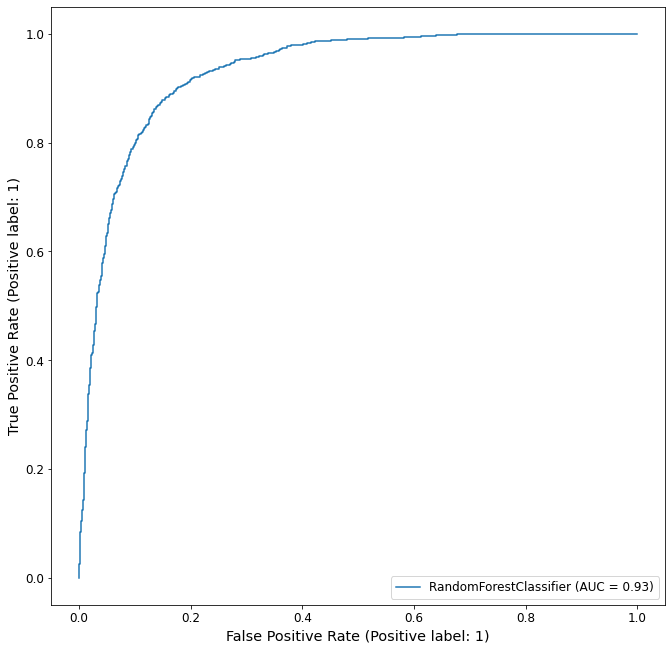

In [49]:
plot_roc_curve(rf_model, X_validation_tree, df_validation['Requires_Paperwork'])

## Principle Component Analysis

Principal components analysis is a means of dimensionality reduction. It can be thought of as somewhat similar to compression. The goal of PCA is to construct a set of vectors that using a small set of numbers (or features) can reconstruct the original data set. A good explanation is [here](https://builtin.com/data-science/step-step-explanation-principal-component-analysis). This will allow us to compress the 800 or so variables that we have in our data set into something much smaller. Below we will compress the 800 or so columns into 20 columns (feel free to experiment with different numbers of components)

In [50]:
n_components = 20

pca = PCA(n_components = n_components)

Let's get the columns we will be compressing.

In [51]:
df_smaller_train.columns[8:]

Index(['Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx)',
       'Diseases of the circulatory system-Diseases of arteries; arterioles; and capillaries+Count*(sk_dim_dx)',
       'Diseases of the musculoskeletal system and connective tissue-Acquired deformities+Count*(sk_dim_dx)',
       'Diseases of the musculoskeletal system and connective tissue-Non-traumatic joint disorders+Count*(sk_dim_dx)',
       'Diseases of the musculoskeletal system and connective tissue-Other connective tissue disease [211.]+Count*(sk_dim_dx)',
       'Diseases of the nervous system and sense organs-Ear conditions+Count*(sk_dim_dx)',
       'Diseases of the nervous system and sense organs-Other nervous system disorders [95.]+Count*(sk_dim_dx)',
       'Diseases of the nervous system and sense organs-Paralysis [82.]+Count*(sk_dim_dx)',
       'Endocrine; nutritional; and metabolic diseases and immunity disorders-Other nutritional; endocrine; and metabolic disorders [58.]+Count*(sk

Fit the pca function.

In [52]:
pca.fit(df_smaller_train[df_smaller_train.columns[8:]])

PCA(n_components=20)

Now we will reconstruct the twenty factors for each row in our smaller training set.

In [53]:
df_smaller_train_PCA = pca.transform(df_smaller_train[df_smaller_train.columns[8:]])

In [54]:
df_smaller_train_PCA

array([[ 4.29322908, -3.21851999, -2.27931857, ..., -6.27415533,
         5.02044167,  2.34189534],
       [-0.86919981, -2.20067916, -2.6539226 , ..., -0.15227019,
         1.47429002,  0.69920247],
       [ 1.16663746, -0.82554835, -2.80771633, ...,  0.90362936,
        -2.21015447, -1.43209774],
       ...,
       [-5.1775781 , -1.41408256,  2.37189861, ..., -0.08443513,
         0.11019877,  0.26901215],
       [-5.0196073 ,  0.05341819,  2.48759316, ...,  0.35953439,
         1.53045513, -0.78247245],
       [-2.16522824, -1.94472688, -4.18590393, ..., -0.459609  ,
        -1.80883853, -1.0165046 ]])

Now we will create a dataframe for the PCA factors.

In [55]:
PCA_df_smaller_train = pd.DataFrame(df_smaller_train_PCA, columns=["PCA_" + str(i) for i in range(1,df_smaller_train_PCA.shape[1] + 1)], index = df_smaller_train.index)

Then combine that with our original data frame, replacing the original factors.

In [56]:
df_smaller_train_with_PCA = pd.concat([df_smaller_train[df_smaller_train.columns[:8]], PCA_df_smaller_train], axis=1)

Let's see what we have.

In [57]:
df_smaller_train_with_PCA

Requires_Paperwork Unique_Patient_ID     Sex Marital_Status  \
11572                   1            421230   OTHER        Married   
5257                    1           2395077  Female        Married   
6798                    0             88417   OTHER        Married   
16229                   1            117584   OTHER        Widowed   
10385                   1            929614   OTHER        Married   
...                   ...               ...     ...            ...   
10428                   0            489719  Female        Widowed   
9082                    0            958287   OTHER         Single   
1891                    0           2381641  Female        Married   
501                     0            753436   OTHER         Single   
7680                    0             OTHER  Female         Single   

      Payment_Class Previous_Discharge_Type       Age  ReadmissionCount  \
11572      Medicare                    NONE  1.292643          0.474325   
5257       Medicare                    NONE  1.230061         -0.436970   
6798    Blue Shield                    NONE -0.084142         -0.436970   
16229      Medicare                    NONE  1.730710          0.474325   
10385      Medicare                    NONE  1.042318         -0.436970   
...             ...                     ...       ...               ...   
10428      Medicare                    NONE  1.417805          0.474325   
9082    Blue Shield                    NONE -1.711251         -0.436970   
1891       Self-pay                    NONE -0.209304         -0.436970   
501        Medicare                    NONE -1.711251         -0.436970   
7680    Blue Shield                    NONE  0.166183         -0.436970   

           PCA_1     PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
11572   4.293229 -3.218520 -2.279319 -0.588184 -0.334733 -2.512213 -0.537455   
5257   -0.869200 -2.200679 -2.653923  0.536814 -0.130352  0.037216  0.048936   
6798    1.166637 -0.825548 -2.807716  0.939326 -0.388518 -1.869595 -0.180434   
16229  -0.424156 -1.384960 -1.756430  0.497034  1.026303  0.385538 -0.906916   
10385  14.917372 -5.371324  6.403021 -4.165530 -0.669850 -6.190027  4.341683   
...          ...       ...       ...       ...       ...       ...       ...   
10428   2.535484 -0.449048 -2.801597 -1.242281  1.932352  1.324254  1.050276   
9082   -5.177578 -1.414083  2.371899 -0.707005  0.097421  0.148819 -0.300197   
1891   -5.177578 -1.414083  2.371899 -0.707005  0.097421  0.148819 -0.300197   
501    -5.019607  0.053418  2.487593 -0.900509 -0.400835  0.005594 -0.224086   
7680   -2.165228 -1.944727 -4.185904  1.518625 -0.597034  2.312987  4.544518   

          PCA_8     PCA_9    PCA_10    PCA_11    PCA_12    PCA_13    PCA_14  \
11572 -1.789001 -2.928923  3.296107  1.615594 -1.055464  0.934435  0.624493   
5257  -1.080984 -0.054249  1.009287  0.014603 -1.366352  0.151781  0.599105   
6798  -0.419388  1.212946 -0.571534 -0.011908 -0.434338  0.622916  1.765082   
16229  1.904852  0.515248 -1.343001 -0.402186  2.015522 -1.624100 -0.682283   
10385 -1.257848 -1.679532  2.443158 -2.514493 -0.460238  1.125743 -2.680608   
...         ...       ...       ...       ...       ...       ...       ...   
10428  3.243390 -0.941970 -4.580947  1.126642  0.173421  0.557711  1.049388   
9082   0.078163  0.178932  0.013833 -0.205833  0.018044  0.148483 -0.174398   
1891   0.078163  0.178932  0.013833 -0.205833  0.018044  0.148483 -0.174398   
501   -0.306894 -0.674088  0.237623 -0.220975  0.283559  0.258074 -1.283699   
7680  -1.376187  3.168544 -0.734521 -0.831418  3.503114 -0.417820 -1.430060   

         PCA_15    PCA_16    PCA_17    PCA_18    PCA_19    PCA_20  
11572 -0.217200 -0.117948  0.449422 -6.274155  5.020442  2.341895  
5257  -1.424583 -0.147195 -0.590277 -0.152270  1.474290  0.699202  
6798   0.318822 -1.040492  1.188084  0.903629 -2.210154 -1.432098  
16229 -0.794478 -1.168693 -0.111109 -0.138012  1.570231  0.857801  
10385 -0.371195

Now let's do the same thing with the validation data.

In [58]:
df_validation_PCA = pca.transform(df_validation[df_smaller_train.columns[8:]])
PCA_df_validation = pd.DataFrame(df_validation_PCA, columns=["PCA_" + str(i) for i in range(1,df_validation_PCA.shape[1] + 1)], index = df_validation.index)
df_validation_with_PCA = pd.concat([df_validation[df_smaller_train.columns[:8]], PCA_df_validation], axis=1)

## Random Forest with PCA

Now, let's build a random forest with the PCA components instead of the original data.

First, we will set up our `X` and `y` matrices for the Random Forest Classifier. Note we don't include unique patient ID because that is a lot of possible values, and unlikely to be too useful.

In [59]:
X_train_tree_PCA = df_smaller_train_with_PCA[df_smaller_train_with_PCA.columns[2:]].copy()
y_train_tree_PCA = df_smaller_train_with_PCA['Requires_Paperwork'].copy()

Then we will encode the categorical variables with an ordinal encoder.

In [60]:
categorical_variables = ["Sex", "Marital_Status", "Payment_Class", "Previous_Discharge_Type"]
ordinal_encoder = OrdinalEncoder()

Note that we only want to use the categorical variables, so this is where it is handy that we went ahead and figured out which of our selected variables were categorical above.

In [61]:
ordinal_encoder.fit(X_train_tree_PCA[categorical_variables])
X_train_tree_PCA[categorical_variables] = ordinal_encoder.transform(X_train_tree_PCA[categorical_variables])

We can see that all of the values are now numeric, which means we can use them to build our decision tree.

In [62]:
X_train_tree_PCA

Sex  Marital_Status  Payment_Class  Previous_Discharge_Type       Age  \
11572  1.0             2.0            6.0                      7.0  1.292643   
5257   0.0             2.0            6.0                      7.0  1.230061   
6798   1.0             2.0            1.0                      7.0 -0.084142   
16229  1.0             5.0            6.0                      7.0  1.730710   
10385  1.0             2.0            6.0                      7.0  1.042318   
...    ...             ...            ...                      ...       ...   
10428  0.0             5.0            6.0                      7.0  1.417805   
9082   1.0             4.0            1.0                      7.0 -1.711251   
1891   0.0             2.0           10.0                      7.0 -0.209304   
501    1.0             4.0            6.0                      7.0 -1.711251   
7680   0.0             4.0            1.0                      7.0  0.166183   

       ReadmissionCount      PCA_1     PCA_2     PCA_3     PCA_4     PCA_5  \
11572          0.474325   4.293229 -3.218520 -2.279319 -0.588184 -0.334733   
5257          -0.436970  -0.869200 -2.200679 -2.653923  0.536814 -0.130352   
6798          -0.436970   1.166637 -0.825548 -2.807716  0.939326 -0.388518   
16229          0.474325  -0.424156 -1.384960 -1.756430  0.497034  1.026303   
10385         -0.436970  14.917372 -5.371324  6.403021 -4.165530 -0.669850   
...                 ...        ...       ...       ...       ...       ...   
10428          0.474325   2.535484 -0.449048 -2.801597 -1.242281  1.932352   
9082          -0.436970  -5.177578 -1.414083  2.371899 -0.707005  0.097421   
1891          -0.436970  -5.177578 -1.414083  2.371899 -0.707005  0.097421   
501           -0.436970  -5.019607  0.053418  2.487593 -0.900509 -0.400835   
7680          -0.436970  -2.165228 -1.944727 -4.185904  1.518625 -0.597034   

          PCA_6     PCA_7     PCA_8     PCA_9    PCA_10    PCA_11    PCA_12  \
11572 -2.512213 -0.537455 -1.789001 -2.928923  3.296107  1.615594 -1.055464   
5257   0.037216  0.048936 -1.080984 -0.054249  1.009287  0.014603 -1.366352   
6798  -1.869595 -0.180434 -0.419388  1.212946 -0.571534 -0.011908 -0.434338   
16229  0.385538 -0.906916  1.904852  0.515248 -1.343001 -0.402186  2.015522   
10385 -6.190027  4.341683 -1.257848 -1.679532  2.443158 -2.514493 -0.460238   
...         ...       ...       ...       ...       ...       ...       ...   
10428  1.324254  1.050276  3.243390 -0.941970 -4.580947  1.126642  0.173421   
9082   0.148819 -0.300197  0.078163  0.178932  0.013833 -0.205833  0.018044   
1891   0.148819 -0.300197  0.078163  0.178932  0.013833 -0.205833  0.018044   
501    0.005594 -0.224086 -0.306894 -0.674088  0.237623 -0.220975  0.283559   
7680   2.312987  4.544518 -1.376187  3.168544 -0.734521 -0.831418  3.503114   

         PCA_13    PCA_14    PCA_15    PCA_16    PCA_17    PCA_18    PCA_19  \
11572  0.934435  0.624493 -0.217200 -0.117948  0.449422 -6.274155  5.020442   
5257   0.151781  0.599105 -1.424583 -0.147195 -0.590277 -0.152270  1.474290   
6798   0.622916  1.765082  0.318822 -1.040492  1.188084  0.903629 -2.210154   
16229 -1.624100 -0.682283 -0.794478 -1.168693 -0.111109 -0.138012  1.570231   
10385  1.125743 -2.680608 -0.371195  3.308642  2.256783 -2.370351  0.259414   
...         ...       ...       ...       ...       ...       ...       ...   
10428  0.557711  1.049388  0.220540 -1.686286  1.000153 -0.181270 -0.618389   
9082   0.148483 -0.174398  0.117388 -0.168402 -0.368677 -0.084435  0.110199   
1891   0.148483 -0.174398  0.117388 -0.168402 -0.368677 -0.084435  0.110199   
501    0.258074 -1.283699  1.094240  0.425406 -1.570286  0.359534  1.530455   
7680  -0.417820 -1.430060  1.951658  0.628191  0.703345 -0.459609 -1.808839   

         PCA_20  
11572  2.341895  
5257   0.699202  
6798  -1.432098  
16229  0.857801  
10385  1.518740  
...         ...  
10428 -1.042400  
9082   0.269012  
1891   0.269012  
501   -0.782472  
7680  -1.0165

Let's build our random frest. Note that the only difference between this and the decision tree regression we've used before is the function is called `RandomForestClassifier` instead of `RandomForestRegressor`.

In [63]:
rf_model = RandomForestClassifier(n_estimators=500, max_features=4, min_samples_leaf=5, random_state=201, n_jobs=num_cpus)

In [64]:
rf_model.fit(X_train_tree_PCA, y_train_tree_PCA)

RandomForestClassifier(max_features=4, min_samples_leaf=5, n_estimators=500,
                       n_jobs=2, random_state=201)

We can also look at the feature importance.

In [65]:
pd.DataFrame({'Importance': rf_model.feature_importances_}, index=X_train_tree_PCA.columns).sort_values(['Importance'], ascending=False)

Importance
PCA_6                      0.153408
PCA_15                     0.150943
PCA_12                     0.073524
PCA_19                     0.071649
PCA_1                      0.062167
PCA_7                      0.059100
PCA_3                      0.058563
Age                        0.040798
Previous_Discharge_Type    0.029433
PCA_2                      0.029194
PCA_8                      0.027411
PCA_4                      0.026235
PCA_13                     0.022793
PCA_17                     0.020448
PCA_9                      0.019978
PCA_5                      0.019907
PCA_11                     0.019560
PCA_18                     0.018649
PCA_14                     0.018487
PCA_10                     0.018450
PCA_16                     0.017504
PCA_20                     0.016876
Payment_Class              0.012066
Marital_Status             0.007364
ReadmissionCount           0.003329
Sex                        0.002166

Now, let's prepare our validation data to test on.

In [66]:
X_validation_tree_PCA = df_validation_with_PCA[df_smaller_train_with_PCA.columns[2:]].copy()
y_validation_tree_PCA = df_validation_with_PCA['Requires_Paperwork'].copy()

We have to encode the values in the validation set with the same ordinal encoder.

In [67]:
X_validation_tree_PCA[categorical_variables] = ordinal_encoder.transform(X_validation_tree_PCA[categorical_variables])

In [68]:
rf_pred = rf_model.predict_proba(X_validation_tree_PCA)[:,1]

Let's check the accuracy.

In [69]:
roc_auc_score(df_validation['Requires_Paperwork'], rf_pred)

0.9350164389262676

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


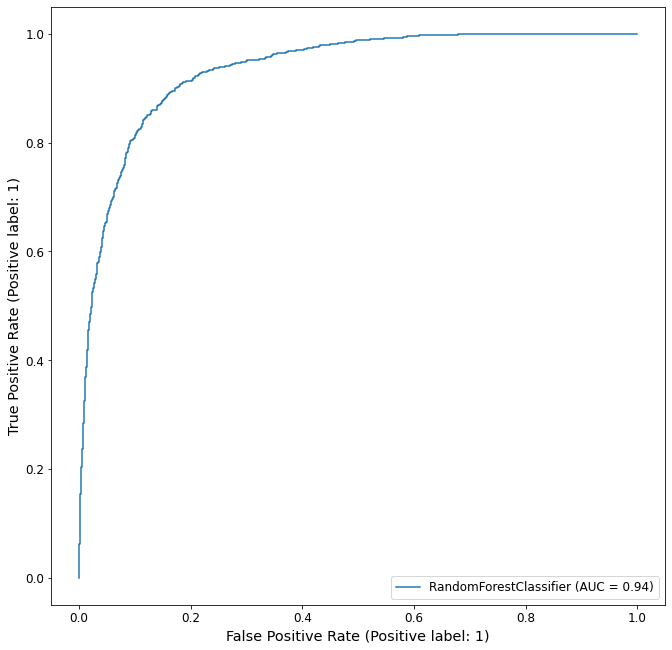

In [70]:
plot_roc_curve(rf_model, X_validation_tree_PCA, df_validation['Requires_Paperwork'])

As you can see, we have achieved better accuracy with significantly fewer columns. Try changing the number of components and see what happens.

## Boosted trees model with PCA

Let's build a boosted trees model.

In [71]:
xgb_model = XGBClassifier(max_depth=6, n_estimators = 50, learning_rate=.1, random_state=201)

In [72]:
xgb_model.fit(X_train_tree_PCA, y_train_tree_PCA)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:55:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1637426272325/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=201,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

We can also look at the feature importance.

In [73]:
pd.DataFrame({'Importance': rf_model.feature_importances_}, index=X_train_tree_PCA.columns).sort_values(['Importance'], ascending=False)

Importance
PCA_6                      0.153408
PCA_15                     0.150943
PCA_12                     0.073524
PCA_19                     0.071649
PCA_1                      0.062167
PCA_7                      0.059100
PCA_3                      0.058563
Age                        0.040798
Previous_Discharge_Type    0.029433
PCA_2                      0.029194
PCA_8                      0.027411
PCA_4                      0.026235
PCA_13                     0.022793
PCA_17                     0.020448
PCA_9                      0.019978
PCA_5                      0.019907
PCA_11                     0.019560
PCA_18                     0.018649
PCA_14                     0.018487
PCA_10                     0.018450
PCA_16                     0.017504
PCA_20                     0.016876
Payment_Class              0.012066
Marital_Status             0.007364
ReadmissionCount           0.003329
Sex                        0.002166

Now we can predict on our validation set.

In [74]:
xgb_pred = xgb_model.predict_proba(X_validation_tree_PCA)[:,1]

Let's check the accuracy.

In [75]:
roc_auc_score(df_validation['Requires_Paperwork'], xgb_pred)

0.9368240271901228

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


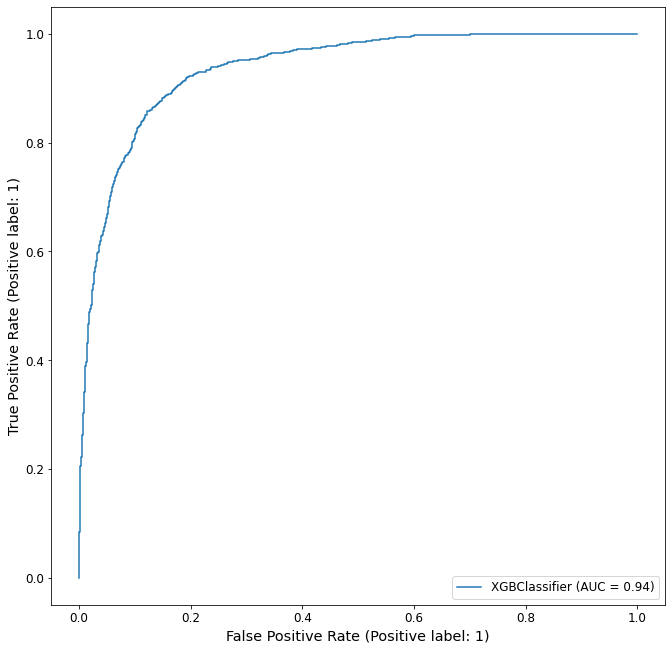

In [76]:
plot_roc_curve(xgb_model, X_validation_tree_PCA, df_validation['Requires_Paperwork'])

## Regularized Logistic Regression with PCA

Let's see what happens when we just try to use a standard regression on all of the data (excluding the unique patient ID because that will create a slew of dummy variables).

In [77]:
formula = 'Requires_Paperwork ~ ' + 'Q("' + '") + Q("'.join(df_smaller_train_with_PCA.columns[2:]) + '")'

Let's check our formula.

In [78]:
formula

'Requires_Paperwork ~ Q("Sex") + Q("Marital_Status") + Q("Payment_Class") + Q("Previous_Discharge_Type") + Q("Age") + Q("ReadmissionCount") + Q("PCA_1") + Q("PCA_2") + Q("PCA_3") + Q("PCA_4") + Q("PCA_5") + Q("PCA_6") + Q("PCA_7") + Q("PCA_8") + Q("PCA_9") + Q("PCA_10") + Q("PCA_11") + Q("PCA_12") + Q("PCA_13") + Q("PCA_14") + Q("PCA_15") + Q("PCA_16") + Q("PCA_17") + Q("PCA_18") + Q("PCA_19") + Q("PCA_20")'

Looks right.

In [79]:
y_train_linear_PCA, X_train_linear_PCA = dmatrices(formula, df_smaller_train_with_PCA, return_type="dataframe")

In [80]:
y_train_linear_PCA

Requires_Paperwork
11572                 1.0
5257                  1.0
6798                  0.0
16229                 1.0
10385                 1.0
...                   ...
10428                 0.0
9082                  0.0
1891                  0.0
501                   0.0
7680                  0.0

[13076 rows x 1 columns]

In [81]:
X_train_linear_PCA

Intercept  Q("Sex")[T.OTHER]  Q("Marital_Status")[T.Legally Separated]  \
11572        1.0                1.0                                       0.0   
5257         1.0                0.0                                       0.0   
6798         1.0                1.0                                       0.0   
16229        1.0                1.0                                       0.0   
10385        1.0                1.0                                       0.0   
...          ...                ...                                       ...   
10428        1.0                0.0                                       0.0   
9082         1.0                1.0                                       0.0   
1891         1.0                0.0                                       0.0   
501          1.0                1.0                                       0.0   
7680         1.0                0.0                                       0.0   

       Q("Marital_Status")[T.Married]  Q("Marital_Status")[T.OTHER]  \
11572                             1.0                           0.0   
5257                              1.0                           0.0   
6798                              1.0                           0.0   
16229                             0.0                           0.0   
10385                             1.0                           0.0   
...                               ...                           ...   
10428                             0.0                           0.0   
9082                              0.0                           0.0   
1891                              1.0                           0.0   
501                               0.0                           0.0   
7680                              0.0                           0.0   

       Q("Marital_Status")[T.Single]  Q("Marital_Status")[T.Widowed]  \
11572                            0.0                             0.0   
5257                             0.0                             0.0   
6798                             0.0                             0.0   
16229                            0.0                             1.0   
10385                            0.0                             0.0   
...                              ...                             ...   
10428                            0.0                             1.0   
9082                             1.0                             0.0   
1891                             0.0                             0.0   
501                              1.0                             0.0   
7680                             1.0                             0.0   

       Q("Payment_Class")[T.Blue Shield]  Q("Payment_Class")[T.Do not use]  \
11572                                0.0                               0.0   
5257                                 0.0                               0.0   
6798                                 1.0                               0.0   
16229                                0.0                               0.0   
10385                                0.0                               0.0   
...                                  ...                               ...   
10428                                0.0                               0.0   
9082                                 1.0                               0.0   
1891                                 0.0                               0.0   
501                                  0.0                               0.0   
7680                                 1.0                               0.0   

       Q("Payment_Class")[T.Grant]  Q("Payment_Class")[T.Liability]  \
11572                          0.0                              0.0   
5257                           0.0                              0.0   
6798                           0.0                              0.0   
16229                          0.0                              0.0   
10385                   

Now, we can train a logistic regression model. For a discussion on non-regularized logistic regression, see ISL chapters 4-4.3.5 (pp. 127-138).

In the regularized logistic regression model, the paramater C is the main tuning parameter here. It controls the degree of regularization (i.e., the penalty for large coefficients in the logistic regression). A large C translate into less regularization. A small C translates into more regularization.

In [82]:
rlr_model = LogisticRegression(C=1/10, random_state=201, max_iter=1000000)
rlr_model.fit(X_train_linear_PCA, y_train_linear_PCA)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.1, max_iter=1000000, random_state=201)

You may get a warning, but ignore it.

We can look at the size of the coefficients that it returned. Note that it is the absolute value of the coefficient that is most important. There is something subtly wrong with interpreting the below as a measure of importance of a variable. Can you figure out what it is?

In [83]:
coef_df = pd.DataFrame({'Importance': rlr_model.coef_[0]}, index=X_train_linear_PCA.columns)
coef_df.reindex(coef_df.Importance.abs().sort_values(ascending=False).index)

Importance
Q("Previous_Discharge_Type")[T.Skilled Nursing ...    1.379218
Q("Payment_Class")[T.Self-pay]                       -1.001071
Q("Previous_Discharge_Type")[T.Home Health Agency]   -0.734676
Q("PCA_15")                                          -0.606631
Q("Previous_Discharge_Type")[T.Infusion / Home]      -0.606466
Q("Marital_Status")[T.Married]                       -0.592647
Q("PCA_12")                                          -0.591625
Q("PCA_6")                                           -0.529366
Q("Previous_Discharge_Type")[T.Acute Rehabilita...    0.457933
Q("Payment_Class")[T.Medicare]                        0.439228
Q("PCA_19")                                           0.370360
Q("Payment_Class")[T.Medicare Managed Care]           0.356115
Q("Age")                                              0.350892
Q("PCA_7")                                           -0.342837
Q("Payment_Class")[T.Liability]                       0.325461
Q("Previous_Discharge_Type")[T.Long Term Care H...   -0.300218
Q("Previous_Discharge_Type")[T.DIS TO LAW ENFORCE]   -0.296091
Q("PCA_3")                                           -0.253193
Q("Payment_Class")[T.Grant]                           0.229102
Q("PCA_14")                                           0.219212
Q("Marital_Status")[T.Legally Separated]             -0.209129
Q("PCA_8")                                           -0.174400
Q("PCA_1")                                            0.174084
Q("Previous_Discharge_Type")[T.SNF / Rehab]           0.159357
Q("Previous_Discharge_Type")[T.NONE]                  0.138218
Q("ReadmissionCount")                                 0.135699
Q("PCA_4")                                           -0.130837
Q("Marital_Status")[T.Single]                         0.104943
Q("Marital_Status")[T.Widowed]                       -0.099902
Q("Payment_Class")[T.OTHER]                          -0.095790
Q("Payment_Class")[T.Do not use]                     -0.085446
Q("Payment_Class")[T.Medicaid]                       -0.079702
Q("PCA_17")                                          -0.071116
Q("Payment_Class")[T.Worker's Comp]                   0.068440
Q("Payment_Class")[T.Unknown]                         0.065506
Q("PCA_10")                                          -0.063623
Q("PCA_11")                                          -0.051157
Q("PCA_13")                                           0.050995
Q("Payment_Class")[T.Tricare]                        -0.050775
Q("Marital_Status")[T.OTHER]                         -0.048157
Q("Sex")[T.OTHER]                                     0.047585
Q("Payment_Class")[T.Blue Shield]                     0.046992
Q("PCA_20")                                          -0.046319
Q("Payment_Class")[T.Medicare Replacement]            0.045709
Q("PCA_9")                                            0.044164
Q("PCA_2")                                           -0.038970
Q("PCA_16")                                           0.032186
Q("Previous_Discharge_Type")[T.HOME]                 -0.029719
Q("Previous_Discharge_Type")[T.OTHER]                -0.021426
Q("PCA_18")                                          -0.017652
Q("PCA_5")                                           -0.008490
Intercept                                            -0.001611

Now we can convert our validation set just like we did in Obama-Clinton to make predictions.

In [84]:
X_validation_linear_PCA = build_design_matrices([X_train_linear_PCA.design_info], df_validation_with_PCA, return_type="dataframe")[0]

In [85]:
rlr_pred = rlr_model.predict_proba(X_validation_linear_PCA)[:,1]

Note that above, we use the method `.predict_proba` instead of `.predict`. That is because the `.predict` method will return only a `0` or a `1` indicating whether or not the car `IsBadBuy`. It will return `1` if the probability is greater than `.5` and `0` otherwise. If we use `.predict_proba`, it will return a probability of the car being either. However, `.predict_proba` gives both the probability of a `0` and the probability of a `1`, so we have to pull out just the probability of a `1` with the `[:,1]` above.

Let's test our predictions.

In [86]:
roc_auc_score(df_validation['Requires_Paperwork'], rlr_pred)

0.9280701949087883

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


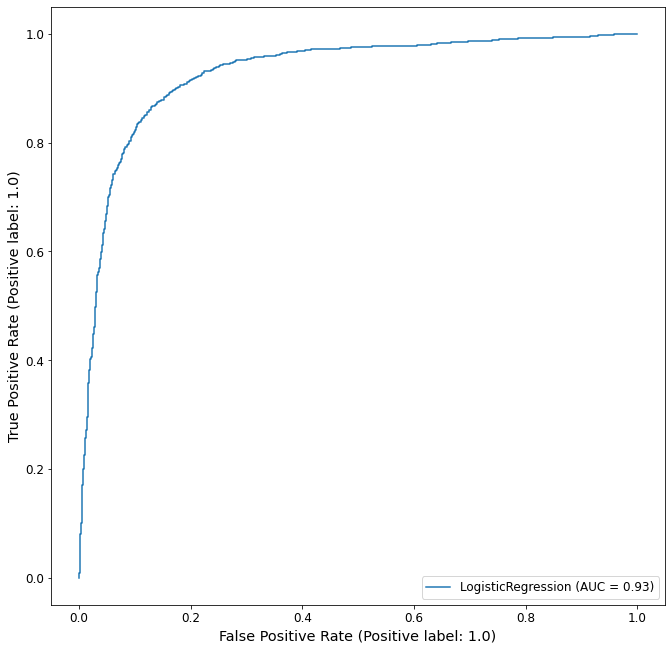

In [87]:
plot_roc_curve(rlr_model, X_validation_linear_PCA, df_validation['Requires_Paperwork'])

## Regularized Logistic Regression without PCA

Let's see what happens when we just try to use a standard regression on all of the data (excluding the unique patient ID because that will create a slew of dummy variables).

In [88]:
formula = 'Requires_Paperwork ~ ' + 'Q("' + '") + Q("'.join(df_smaller_train.columns[2:]) + '")'

Let's check our formula.

In [89]:
formula

'Requires_Paperwork ~ Q("Sex") + Q("Marital_Status") + Q("Payment_Class") + Q("Previous_Discharge_Type") + Q("Age") + Q("ReadmissionCount") + Q("Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx)") + Q("Diseases of the circulatory system-Diseases of arteries; arterioles; and capillaries+Count*(sk_dim_dx)") + Q("Diseases of the musculoskeletal system and connective tissue-Acquired deformities+Count*(sk_dim_dx)") + Q("Diseases of the musculoskeletal system and connective tissue-Non-traumatic joint disorders+Count*(sk_dim_dx)") + Q("Diseases of the musculoskeletal system and connective tissue-Other connective tissue disease [211.]+Count*(sk_dim_dx)") + Q("Diseases of the nervous system and sense organs-Ear conditions+Count*(sk_dim_dx)") + Q("Diseases of the nervous system and sense organs-Other nervous system disorders [95.]+Count*(sk_dim_dx)") + Q("Diseases of the nervous system and sense organs-Paralysis [82.]+Count*(sk_dim_dx)") + Q("Endocrine; nutritional; an

Looks right.

In [90]:
y_train_linear, X_train_linear = dmatrices(formula, df_smaller_train, return_type="dataframe")

In [91]:
y_train_linear

Requires_Paperwork
11572                 1.0
5257                  1.0
6798                  0.0
16229                 1.0
10385                 1.0
...                   ...
10428                 0.0
9082                  0.0
1891                  0.0
501                   0.0
7680                  0.0

[13076 rows x 1 columns]

In [92]:
X_train_linear

Intercept  Q("Sex")[T.OTHER]  Q("Marital_Status")[T.Legally Separated]  \
11572        1.0                1.0                                       0.0   
5257         1.0                0.0                                       0.0   
6798         1.0                1.0                                       0.0   
16229        1.0                1.0                                       0.0   
10385        1.0                1.0                                       0.0   
...          ...                ...                                       ...   
10428        1.0                0.0                                       0.0   
9082         1.0                1.0                                       0.0   
1891         1.0                0.0                                       0.0   
501          1.0                1.0                                       0.0   
7680         1.0                0.0                                       0.0   

       Q("Marital_Status")[T.Married]  Q("Marital_Status")[T.OTHER]  \
11572                             1.0                           0.0   
5257                              1.0                           0.0   
6798                              1.0                           0.0   
16229                             0.0                           0.0   
10385                             1.0                           0.0   
...                               ...                           ...   
10428                             0.0                           0.0   
9082                              0.0                           0.0   
1891                              1.0                           0.0   
501                               0.0                           0.0   
7680                              0.0                           0.0   

       Q("Marital_Status")[T.Single]  Q("Marital_Status")[T.Widowed]  \
11572                            0.0                             0.0   
5257                             0.0                             0.0   
6798                             0.0                             0.0   
16229                            0.0                             1.0   
10385                            0.0                             0.0   
...                              ...                             ...   
10428                            0.0                             1.0   
9082                             1.0                             0.0   
1891                             0.0                             0.0   
501                              1.0                             0.0   
7680                             1.0                             0.0   

       Q("Payment_Class")[T.Blue Shield]  Q("Payment_Class")[T.Do not use]  \
11572                                0.0                               0.0   
5257                                 0.0                               0.0   
6798                                 1.0                               0.0   
16229                                0.0                               0.0   
10385                                0.0                               0.0   
...                                  ...                               ...   
10428                                0.0                               0.0   
9082                                 1.0                               0.0   
1891                                 0.0                               0.0   
501                                  0.0                               0.0   
7680                                 1.0                               0.0   

       Q("Payment_Class")[T.Grant]  Q("Payment_Class")[T.Liability]  \
11572                          0.0                              0.0   
5257                           0.0                              0.0   
6798                           0.0                              0.0   
16229                          0.0                              0.0   
10385                   

Now, we can train a logistic regression model. For a discussion on non-regularized logistic regression, see ISL chapters 4-4.3.5 (pp. 127-138).

In the regularized logistic regression model, the paramater C is the main tuning parameter here. It controls the degree of regularization (i.e., the penalty for large coefficients in the logistic regression). A large C translate into less regularization. A small C translates into more regularization.

In [93]:
rlr_model = LogisticRegression(C=1/10, random_state=201, max_iter=1000000)
rlr_model.fit(X_train_linear, y_train_linear)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=0.1, max_iter=1000000, random_state=201)

You may get a warning, but ignore it.

We can look at the size of the coefficients that it returned. Note that it is the absolute value of the coefficient that is most important. There is something subtly wrong with interpreting the below as a measure of importance of a variable. Can you figure out what it is?

In [94]:
coef_df = pd.DataFrame({'Importance': rlr_model.coef_[0]}, index=X_train_linear.columns)
coef_df.reindex(coef_df.Importance.abs().sort_values(ascending=False).index)

Importance
Q("Previous_Discharge_Type")[T.Skilled Nursing ...    1.402013
Q("Payment_Class")[T.Self-pay]                       -0.843191
Q("Acute rehab+First*(PTValue)")                      0.822509
Q("Subacute rehab/SNF+First*(PTValue)")               0.808786
Q("Previous_Discharge_Type")[T.Home Health Agency]   -0.801108
...                                                        ...
Q("Endocrine & Metabolic Drugs-Contraceptives-P...    0.000000
Q("DME ALTERNATING MATTRESS REPLACEMENT SYSTEM+...    0.000000
Q("DME IMMOBILIZER, KNEE+Count*(sk_Dim_Clrt_EAP...    0.000000
Q("DME WHEELCHAIR, PEDIATRIC W ELEVATED LEG RES...    0.000000
Q("AMPAC_Scaled_Score")                               0.000000

[856 rows x 1 columns]

Now we can convert our validation set just like we did in Obama-Clinton to make predictions.

In [95]:
X_validation_linear = build_design_matrices([X_train_linear.design_info], df_validation, return_type="dataframe")[0]

In [96]:
X_validation_linear.shape

(4359, 856)

In [97]:
rlr_pred = rlr_model.predict_proba(X_validation_linear)[:,1]

Note that above, we use the method `.predict_proba` instead of `.predict`. That is because the `.predict` method will return only a `0` or a `1` indicating whether or not the car `IsBadBuy`. It will return `1` if the probability is greater than `.5` and `0` otherwise. If we use `.predict_proba`, it will return a probability of the car being either. However, `.predict_proba` gives both the probability of a `0` and the probability of a `1`, so we have to pull out just the probability of a `1` with the `[:,1]` above.

Let's test our predictions.

In [98]:
roc_auc_score(df_validation['Requires_Paperwork'], rlr_pred)

0.9393601997641673

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


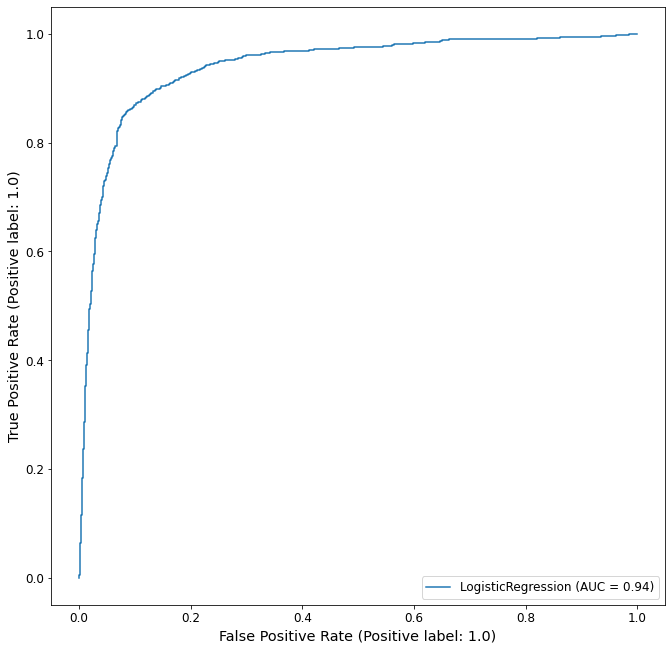

In [99]:
plot_roc_curve(rlr_model, X_validation_linear, df_validation['Requires_Paperwork'])

It does better than using PCA with the logistic regression model. You should see that no matter how many components you use, it will generally always do better. Why is that? Come to class with some thoughts.

## Neural Networks

In this section, we will be training neural networks. Neural networks have slightly different regularization parameters than what we have seen in the past. Please see Introduction to Statistical Learning sections 10.0-10.2 for an introduction to neural networks.

The main tuning parameter in a neural network are the size and number of _hidden layers_. This is tuned with a parameter called `hidden_layer_sizes`. `hidden_layer_sizes` takes as a value a _tuple_ where the length of the tuple is the number of layers and each element of the tuple, from left to right, are the number of nodes in each hidden layer. For example, `hidden_layer_sizes = (5, 4, 6)` specifies a neural network with three hidden layers where the first hidden layer has five nodes, the second four nodes, and the third six nodes. Similarly, `hidden_layer_sizes = (5, 4)` would specify a network with two hidden layers where the first hidden layer has five nodes and the second four nodes. In order to specify a single hidden layer, you would write `hidden_layer_sizes = (5,)` (note the comma) which would create a neural network with one hidden layer with five nodes.

The other parameter that can be tuned is the _activation function_ (see ISL 10.1 for a discussion around activation functions). However, the default value of `relu` is typically the best choice in most situations.

You can see a full list of tuning parameters at the sklearn documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). Note that there is an element of randomness in training neural networks, so we include a `random_state` in order to ensure that the neural network is trained consistently whenever we re-run the code. The value of `random_state` is entirely arbitrary. We also set `max_iter` to a large value just to ensure that the training process finishes correctly.

## Neural Network with PCA

Let's now see what happens when we use a neural network with PCA. Given that neural networks are really very similar to linear models in many ways, we will use the same `X_train_linear_PCA` we created for logistic regression.

In [100]:
%%time
nn_model = MLPClassifier(activation='relu', hidden_layer_sizes=(4,3), random_state=23, max_iter=1000)
nn_model.fit(X_train_linear_PCA, y_train_linear_PCA)

/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 3.81 s, sys: 0 ns, total: 3.81 s
Wall time: 3.81 s


MLPClassifier(hidden_layer_sizes=(4, 3), max_iter=1000, random_state=23)

And we can get our test predictions:

In [101]:
nn_pred = nn_model.predict_proba(X_validation_linear_PCA)[:,1]

Let's test our predictions.

In [102]:
roc_auc_score(df_validation['Requires_Paperwork'], nn_pred)

0.941026565859749

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


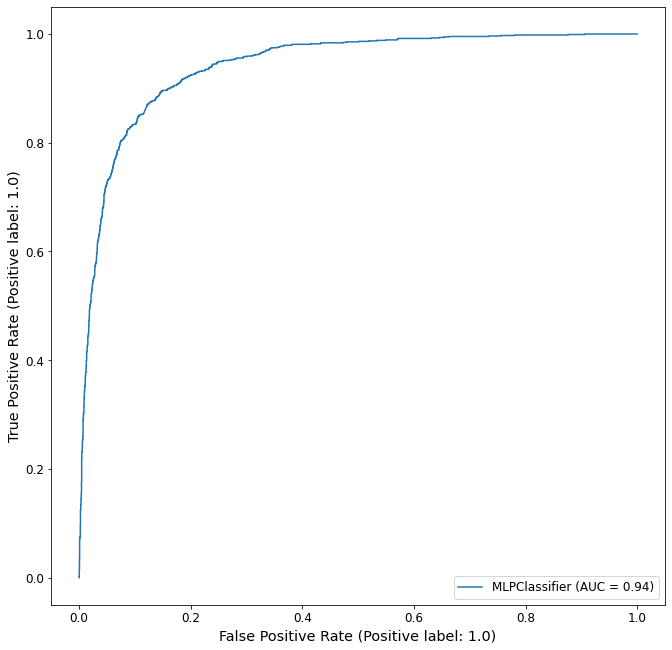

In [103]:
plot_roc_curve(nn_model, X_validation_linear_PCA, df_validation['Requires_Paperwork'])

## Neural Network without PCA

Similar to the above, we will use `X_train_linear` with the neural network.

In [104]:
%%time
nn_model = MLPClassifier(activation='relu', hidden_layer_sizes=(4,3), random_state=23, max_iter=1000)
nn_model.fit(X_train_linear, y_train_linear)

/opt/conda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 1min 6s, sys: 45.6 s, total: 1min 52s
Wall time: 56.3 s


MLPClassifier(hidden_layer_sizes=(4, 3), max_iter=1000, random_state=23)

And we can get our test predictions:

In [105]:
nn_pred = nn_model.predict_proba(X_validation_linear)[:,1]

Let's test our predictions.

In [106]:
roc_auc_score(df_validation['Requires_Paperwork'], nn_pred)

0.892437539016439

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


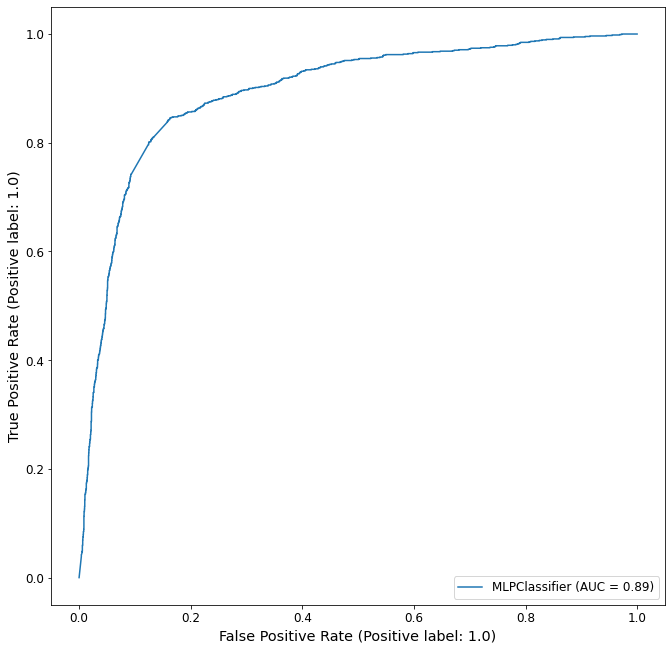

In [107]:
plot_roc_curve(nn_model, X_validation_linear, df_validation['Requires_Paperwork'])

Not quite as good with PCA. Can you tune the neural network to do better? What is the connection between neural networks and PCA?

# Forecast on the Test Set

Now, it's your turn to forecast on the test set. Their are a number of steps you will need to do to get to the point where you can compute your AUC on the test set. You will have to:
* Train imputers on the full training set and then impute on the training and test sets.
* Train the scaler for the continuous variables using the full training set and then scaling the train and test sets.
* Compute the X_train and y_train matrices using the full training set, and create X_test and y_test matrices using the test set.
* Build models and compute the AUC.
Note that one way to do this is to create a copy of this notebook, delete the section about splitting the training set into smaller train and validation set, and then replace `smaller_train` with `train` everywhere and `validation` with `test`.

Come to class with your AUC on the test set.